Define The Grid

In [5]:
import numpy as np
import pyvista as pv

nz_dims = 6
nxy_dims = 20

nz_ratio_dims = nz_dims + 1
nxy_ratio_dims = int(nxy_dims * 1)

xyz_dims = np.array([nxy_ratio_dims, nxy_ratio_dims, nz_ratio_dims])
xyz_dims_plus1 = [xyz_dims[0] + 1, xyz_dims[1] + 1, xyz_dims[2] + 1]

xyz_spacing = (nxy_dims / xyz_dims[0], nxy_dims / xyz_dims[1], 1)
xyz_grid = pv.UniformGrid(
    dims=xyz_dims_plus1,
    spacing=xyz_spacing,
    origin=(0, 0, 0),
)

xyz_points = np.transpose(xyz_grid.points.T)

Find contour points

In [6]:
import cv2 as cv
from matplotlib.path import Path
import matplotlib.patches as patches

names = [
    'sq-0001.png',
    'sq-0002.png',
    'sq-0003.png',
    'sq-0004.png',
    'sq-0005.png',
    'sq-0006.png',
]
input_path = 'images/sq-object'

stacked_contour_points = []
for name in names:
    image_memory = cv.imread(f'{input_path}/{name}')
    inverted_image = cv.bitwise_not(image_memory)
    img_gray = cv.cvtColor(inverted_image, cv.COLOR_BGR2GRAY)
    ret, thresh = cv.threshold(img_gray, 150, 255, cv.THRESH_BINARY)
    im2, contours, hierarchy = cv.findContours(image=thresh, mode=cv.RETR_TREE, method=cv.CHAIN_APPROX_NONE)

    multi_points = []
    for contour in contours:
        contour_points = contour[:, 0]
        path = Path(contour_points, closed=True)
        patch = patches.PathPatch(path, facecolor=None, lw=1, antialiased=True)
        vertices = patch.get_path().vertices
        trans = patch.get_patch_transform()
        points = trans.transform(vertices)
        multi_points.append(points)
    stacked_contour_points.append(multi_points)
stacked_contour_points.insert(0, [])
stacked_contour_points.append([])

Define point clouds

In [7]:
from shapely.geometry import Polygon, MultiPolygon, Point

object_index = []
xyz_points_object = []
for z in np.arange(0, xyz_dims_plus1[2], 1):
    multi_multipolygon = []
    for points in stacked_contour_points[z]:
        poly = Polygon(points)
        poly_big = poly.buffer(1e-6)
        if poly_big.geom_type == 'MultiPolygon':
            pass
        elif poly_big.geom_type == 'Polygon':
            poly_big = MultiPolygon([poly_big])
        else:
            pass
        multi_multipolygon.append(poly_big)

    for i, o in enumerate(np.array(list(filter(lambda c: c[2] == z, xyz_points)))):
        point = Point(o[:2])
        inserted = False
        for multipolygon in multi_multipolygon:
            if multipolygon.contains(point):
                xyz_points_object.append(o)
                inserted = True
                break
        object_index.append(1 if inserted else 0)

xyz_points_object

[array([2., 2., 1.]),
 array([3., 2., 1.]),
 array([4., 2., 1.]),
 array([5., 2., 1.]),
 array([6., 2., 1.]),
 array([7., 2., 1.]),
 array([8., 2., 1.]),
 array([9., 2., 1.]),
 array([10.,  2.,  1.]),
 array([11.,  2.,  1.]),
 array([12.,  2.,  1.]),
 array([13.,  2.,  1.]),
 array([14.,  2.,  1.]),
 array([15.,  2.,  1.]),
 array([16.,  2.,  1.]),
 array([17.,  2.,  1.]),
 array([2., 3., 1.]),
 array([3., 3., 1.]),
 array([4., 3., 1.]),
 array([5., 3., 1.]),
 array([6., 3., 1.]),
 array([7., 3., 1.]),
 array([8., 3., 1.]),
 array([9., 3., 1.]),
 array([10.,  3.,  1.]),
 array([11.,  3.,  1.]),
 array([12.,  3.,  1.]),
 array([13.,  3.,  1.]),
 array([14.,  3.,  1.]),
 array([15.,  3.,  1.]),
 array([16.,  3.,  1.]),
 array([17.,  3.,  1.]),
 array([2., 4., 1.]),
 array([3., 4., 1.]),
 array([4., 4., 1.]),
 array([5., 4., 1.]),
 array([6., 4., 1.]),
 array([7., 4., 1.]),
 array([8., 4., 1.]),
 array([9., 4., 1.]),
 array([10.,  4.,  1.]),
 array([11.,  4.,  1.]),
 array([12.,  4.,  1.]

Show the points cloud

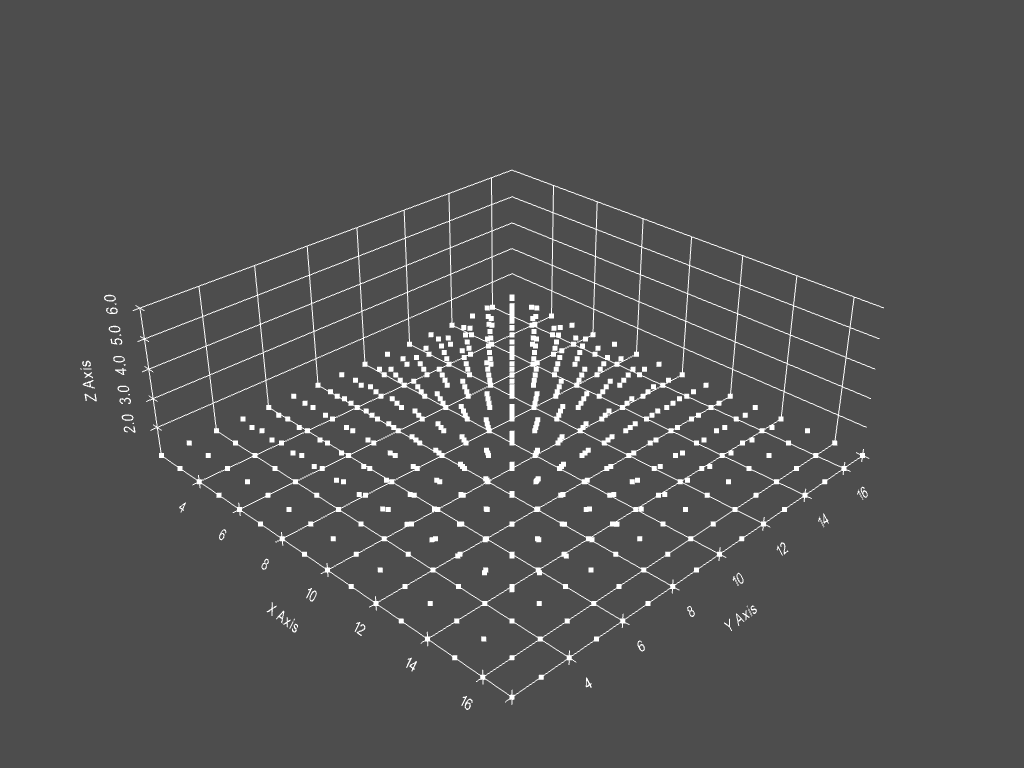

In [8]:
plot = pv.Plotter()
plot.add_points(np.array(xyz_points_object))
plot.camera_position = 'xy'
plot.show_bounds()
plot.show_grid()
plot.camera_position = 'yz'
plot.camera.azimuth = -45.0
plot.camera.elevation = 30.0
plot.show()